# Dimension reduction and manifold learning - Master MASH - Dauphine PSL
# Python Practice
# Exploring Linear and Non-Linear Dimensionality Reduction
### **Practice Overview:**

- **Objective**: Understand Principal Component Analysis, ISOMAP and how they can capture or fail to capture the intrinsic geometry of data.
- **Concepts Covered**:
  - Principal component analysis (PCA)
  - ISOMAP
### **Key Takeaways:**
  - PCA only captures (global) linear geometry of data
  - ISOMAP does capture intrinsic geometry of data, but is bad at clustering
  - ISOMAP is relatively insensitive to the number of nearest neigbhors within a smooth range of values
  - Both methods are sensitive to outliers

Load the necessary packages

In [43]:
import numpy as np
import scipy as sp
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial import procrustes
from scipy.spatial.distance import pdist, squareform
from matplotlib import colormaps

from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import floyd_warshall

### Coding classical scaling (and its Landmark version)
Implement Classical Scaling from scratch.

In [44]:
def MDS_DIY(D, dim=2):
    # Step 1: Double centering of the distance matrix
    n = D.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * H.dot(D**2).dot(H)
    
    # Step 2: Eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    
    # Step 3: Sort eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # Step 4: Select the top n_components eigenvectors and eigenvalues
    eigvals_top = eigvals[:dim]
    eigvecs_top = eigvecs[:, :dim]
    
    # Step 5: Project the points into the new space
    X_transformed = eigvecs_top * np.sqrt(eigvals_top)
    
    return X_transformed, eigvals

In [45]:
def landmark_MDS_DIY(D, lands, dim=2):
    # http://graphics.stanford.edu/courses/cs468-05-winter/Papers/Landmarks/Silva_landmarks5.pdf
    Dl = D[:,lands]
    n = len(Dl)

    # Centering matrix
    H = - np.ones((n, n))/n
    np.fill_diagonal(H,1-1/n)
    # YY^T
    H = -H.dot(Dl**2).dot(H)/2

    # Diagonalize
    evals, evecs = np.linalg.eigh(H)

    # Sort by eigenvalue in descending order
    idx   = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]

    # Compute the coordinates using positive-eigenvalued components only
    w, = np.where(evals > 0)
    if dim:
        arr = evals
        w = arr.argsort()[-dim:][::-1]
        if np.any(evals[w]<0):
            print('Error: Not enough positive eigenvalues for the selected dim.')
            return []
    if w.size==0:
        print('Error: matrix is negative definite.')
        return []

    #Applying Classical MDS to the landmark distance matrix Dl
    V = evecs[:,w]
    L = V.dot(np.diag(np.sqrt(evals[w]))).T
    N = D.shape[1]
    Lh = V.dot(np.diag(1./np.sqrt(evals[w]))).T
    #Extrapolating to get trilateration of the rest
    Dm = D - np.tile(np.mean(Dl,axis=1),(N, 1)).T
    dim = w.size
    X = -Lh.dot(Dm)/2.
    X -= np.tile(np.mean(X,axis=1),(N, 1)).T

    _, evecs = sp.linalg.eigh(X.dot(X.T))

    return (evecs[:,::-1].T.dot(X)).T, evals

### Cumulated eigenvalues plot
To understand how many dimensions are required to capture most of the variance, write a function that allows to visualize how quickly the eigenvalues decay

In [46]:
def plot_eigenvalue_decay(eigenvalues):
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(eigenvalues)/np.sum(eigenvalues), 'o-', color='blue')
    plt.title('Explained variance')
    plt.xlabel('Component Index')
    plt.ylabel('Cumulated eigenvalues')
    plt.grid(True)
    plt.show()

In [47]:
# Side by side version
def side_by_side_decay(eigenvalues1,eigenvalues2, nval = -1):
    n=0
    if nval == -1:
        n = len(eigenvalues1)-1
    else:
        n = nval
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(abs(eigenvalues1))[0:n]/np.sum(abs(eigenvalues1)), 'o-', color='blue',label="PCA")
    plt.plot(np.cumsum(abs(eigenvalues2))[0:n]/np.sum(abs(eigenvalues2)), 'o-', color='red',label="ISOMAP")
    plt.title('Explained variance compared')
    plt.xlabel('Component Index')
    plt.ylabel('Cumulated eigenvalues')
    plt.grid(True)
    plt.show()

### Writing a function that computes shortest path distances in a k-NN graph

In [48]:
def kNN_distance_matrix(X, n_neighbors=10):
    # Step 1: Compute the full pairwise distance Euclidean matrix
    dist_matrix = distance_matrix(X, X)
    
    # Step 2: Construct the nearest-neighbor graph
    n_samples = X.shape[0]
    neighbor_graph = np.full((n_samples, n_samples), np.inf)
    for i in range(n_samples):
        # Get indices of the nearest neighbors (excluding itself)
        neighbors = np.argsort(dist_matrix[i])[:n_neighbors + 1]
        for j in neighbors:
            neighbor_graph[i, j] = dist_matrix[i, j]
            neighbor_graph[j, i] = dist_matrix[j, i]  # Make it symmetric

    # Step 3: Compute shortest paths (Floyd-Warshall algorithm)
    shortest_path_matrix = floyd_warshall(neighbor_graph, directed=False)
    
    # Step 4: Dealing with possible Inf by adding a large distance value between the disconnected components 
    shortest_path_matrix[shortest_path_matrix==np.inf] = 3* np.max(shortest_path_matrix[shortest_path_matrix<np.inf])

    return shortest_path_matrix

### Writing a function that plots two point clouds side by side

In [49]:
def side_by_side_plot(Xpca,Xisomap,colors):
    # Create a figure with 1 row and 2 columns of subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the first set of points on the first subplot
    axes[0].scatter(Xpca[:, 0], Xpca[:, 1], c=colors, s=5)
#    axes[0].set_aspect('equal', adjustable='box')
    axes[0].set_title("PCA")

    # Plot the second set of points on the second subplot
    axes[1].scatter(Xisomap[:, 0], Xisomap[:, 1], c=colors, s=5)
#    axes[1].set_aspect('equal', adjustable='box')
    axes[1].set_title("ISOMAP")

    # Display the plots side by side
    plt.tight_layout()
    plt.show()

## Testing on 3D toy data
The infamous "Swiss roll"

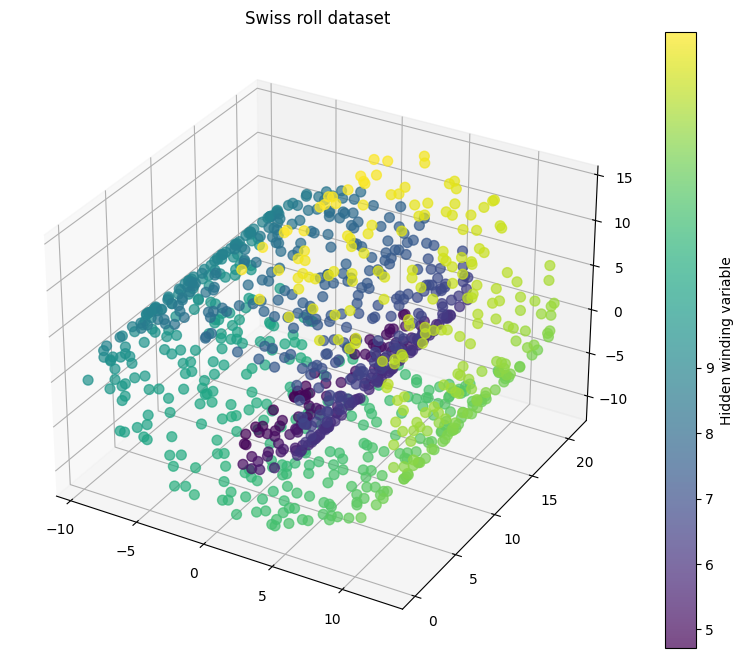

In [50]:
# Dataset
x_roll, c = datasets.make_swiss_roll(n_samples=1000)

# Apply MDS to reduce dimensions to 3D
pick = random.sample(range(0,x_roll.shape[1],1),3)
x = x_roll[:,pick]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D, color by digit class
scatter = ax.scatter(x_roll[:, 0], x_roll[:, 1], x_roll[:, 2], c=c, s=50, alpha=0.7)

# Add color bar (legend for digit classes)
cb = fig.colorbar(scatter, ax=ax, ticks=range(10))
cb.set_label('Hidden winding variable')

# Add labels and title
ax.set_title('Swiss roll dataset')

# Show plot
plt.show()

Compare PCA and ISOMAP on the swiss roll data. Play around with the number of nearest neighbors used for ISOMAP

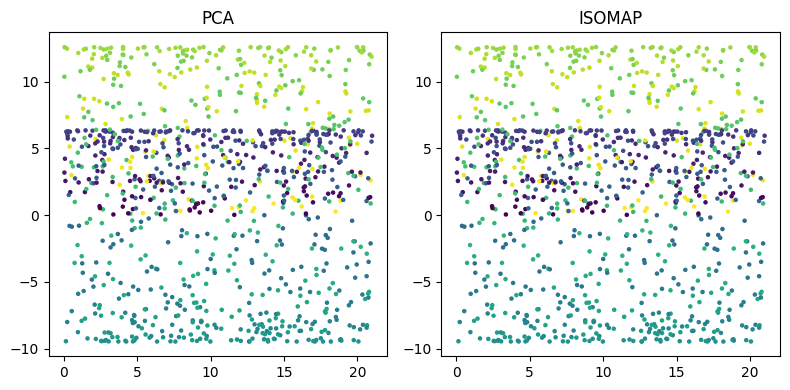

In [51]:
#Here is the dataset loaded with two random vizualisations of it.

pick = random.sample(range(0,x_roll.shape[1],1),2)
y1 = x_roll[:,pick]

pick = random.sample(range(0,x_roll.shape[1],1),2)
y2 = x_roll[:,pick]

side_by_side_plot(y1,y2,c)

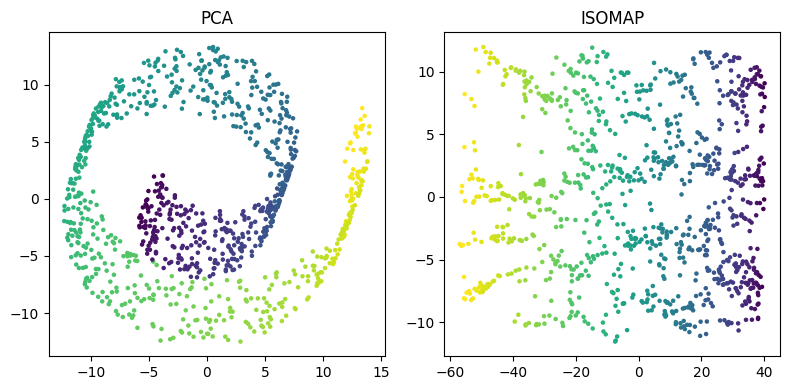

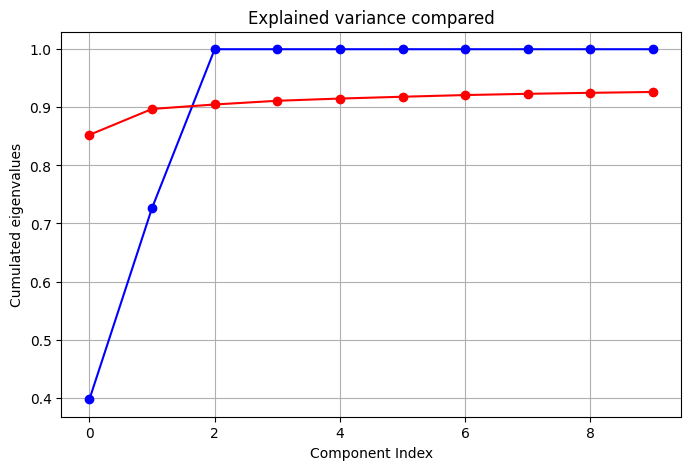

In [52]:
Eucl_dist_matrix = distance_matrix(x_roll,x_roll)
Xpca, eigs_pca = MDS_DIY(Eucl_dist_matrix)

kNN_dist_matrix = kNN_distance_matrix(x_roll, n_neighbors=6)
Xisomap, eigs_isomap = MDS_DIY(kNN_dist_matrix)

side_by_side_plot(Xpca,Xisomap,c)
side_by_side_decay(eigs_pca,eigs_isomap,10)

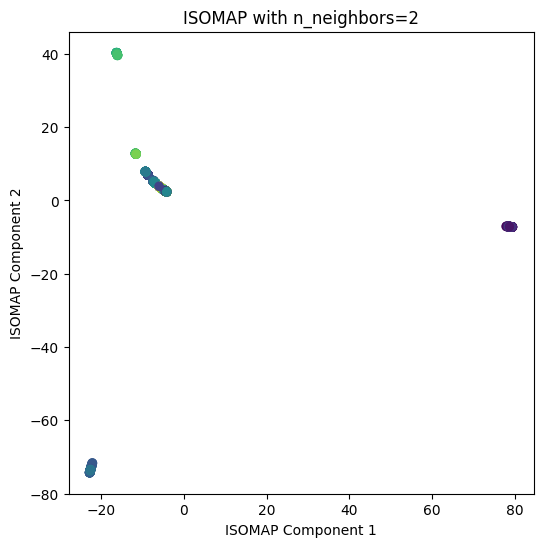

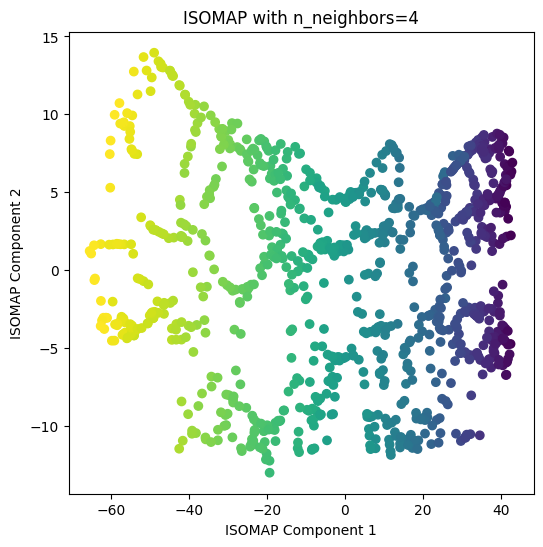

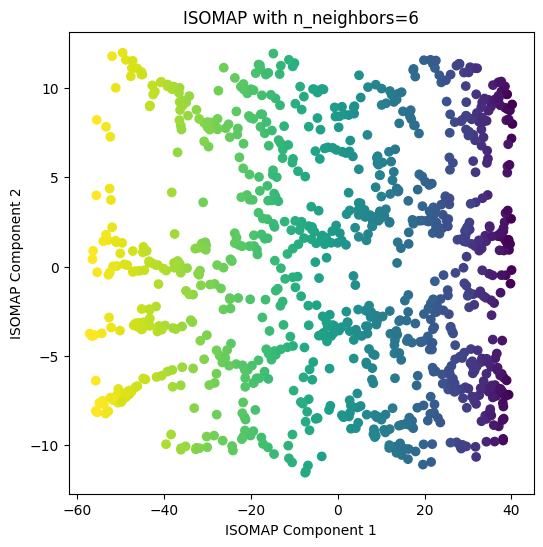

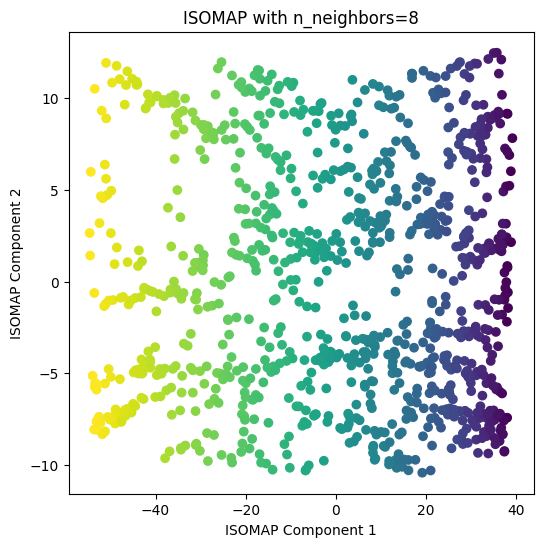

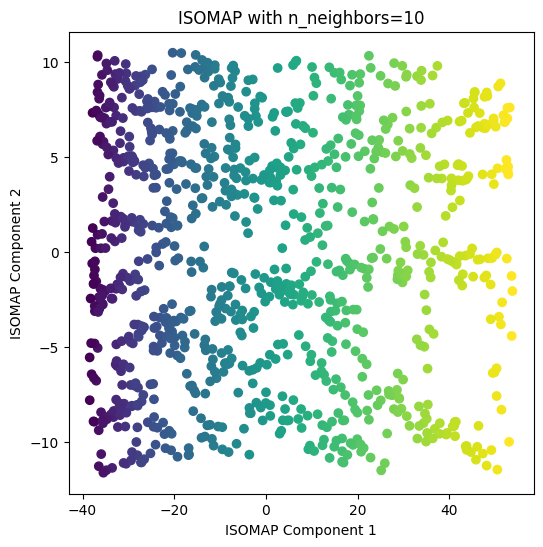

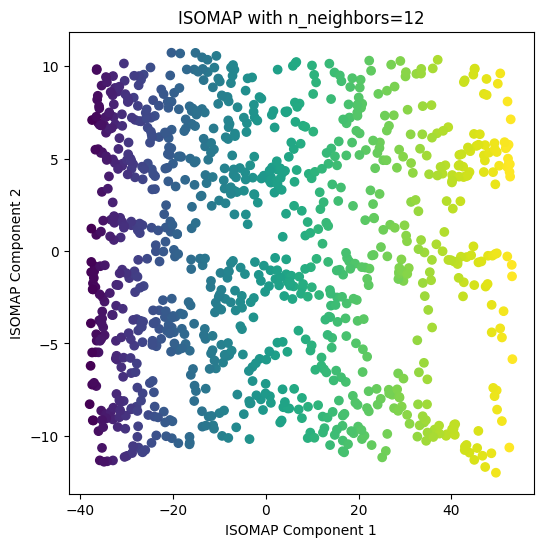

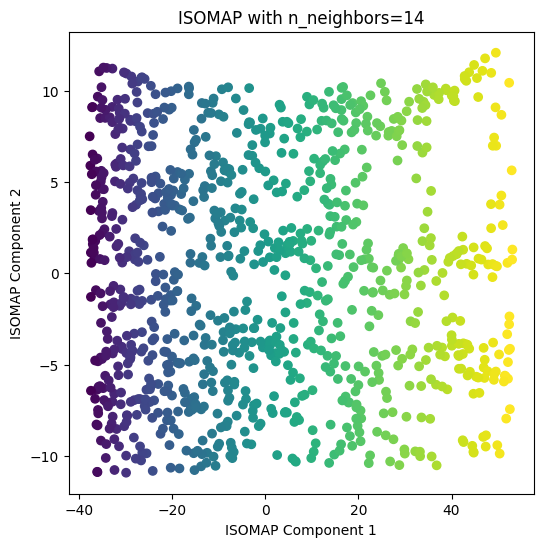

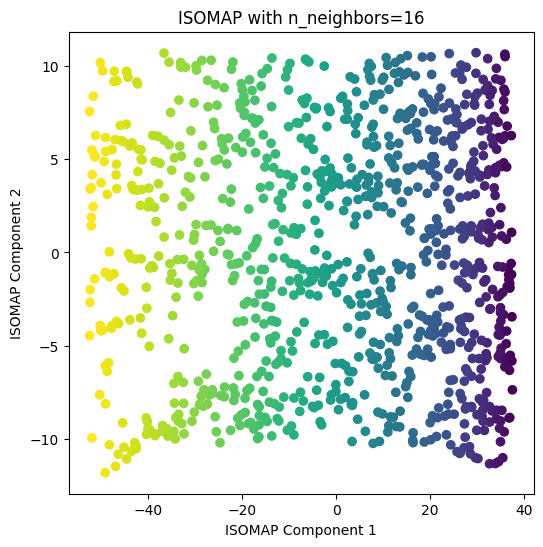

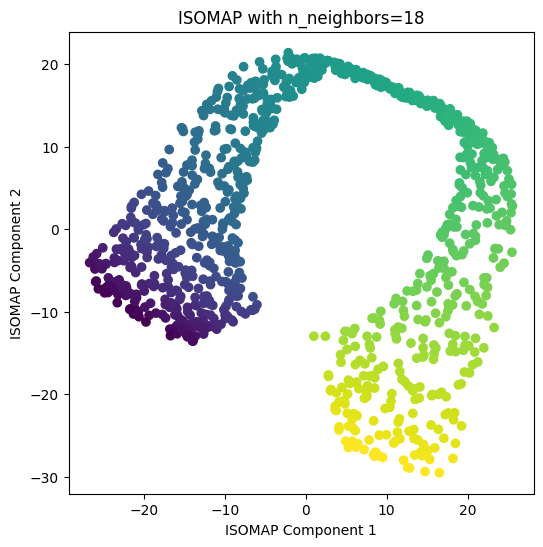

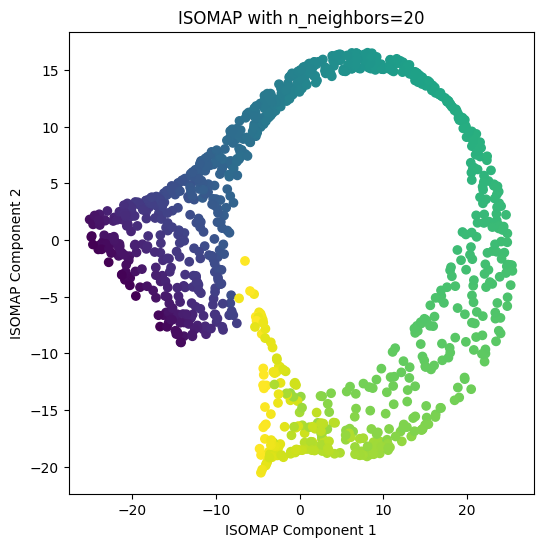

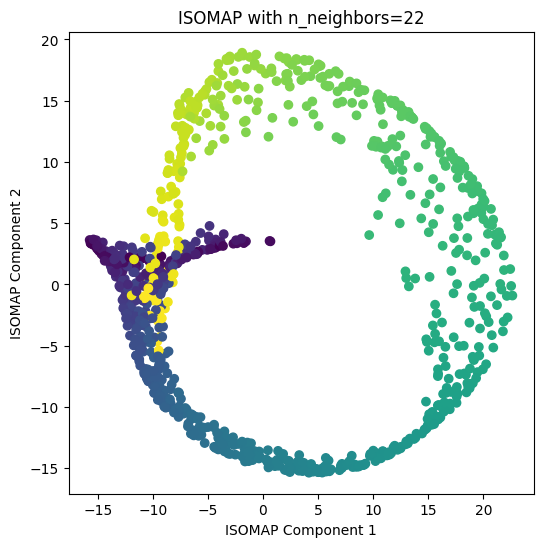

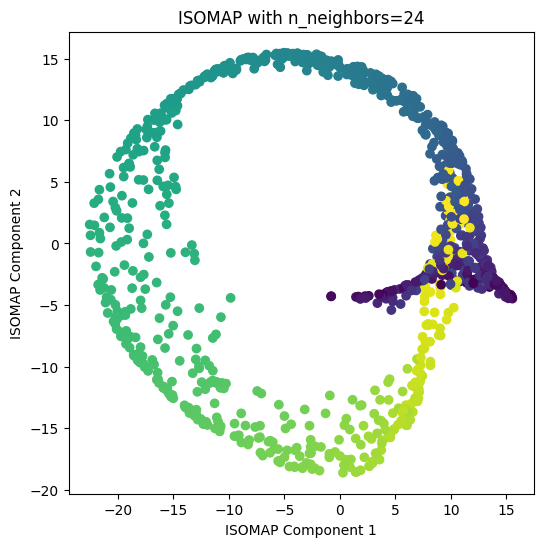

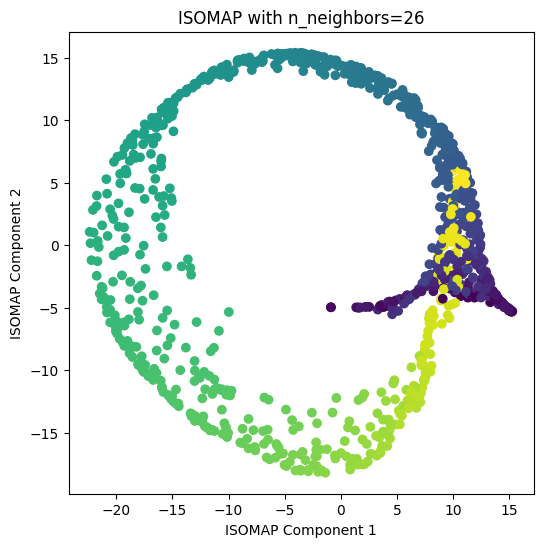

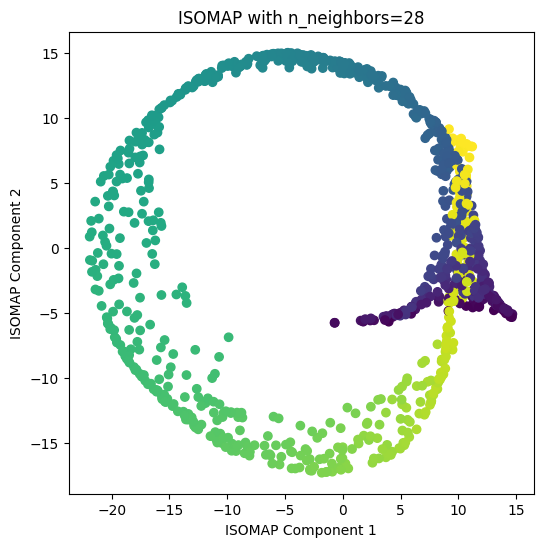

In [53]:
# Experimenting with different n_neighbors
for n in range(2,30,2):
    kNN_dist_matrix = kNN_distance_matrix(x_roll, n_neighbors=n)
    Xisomap, eigs_isomap = MDS_DIY(kNN_dist_matrix)

    plt.figure(figsize=(6, 6))
    plt.scatter(Xisomap[:, 0], Xisomap[:, 1], c=c)
    plt.title(f"ISOMAP with n_neighbors={n}")
    plt.xlabel("ISOMAP Component 1")
    plt.ylabel("ISOMAP Component 2")
    plt.show()

## Iris dataset
Compare PCA and ISOMAP on the Iris dataset. Play around with the number of nearest neighbors used for ISOMAP

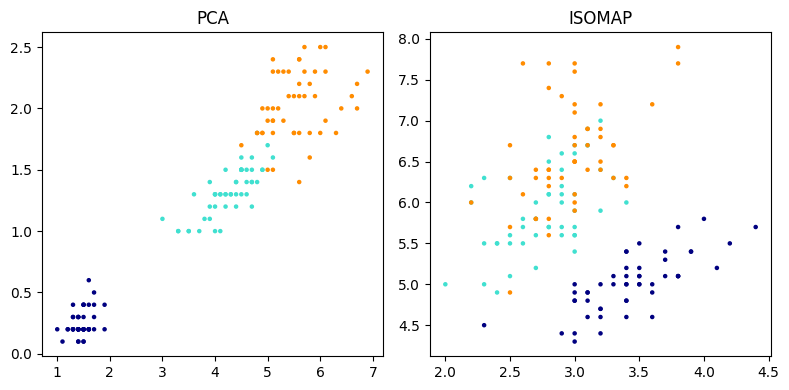

In [54]:
#Here is the dataset loaded with a random vizualisation of it.
from scipy.spatial import distance
from sklearn.datasets import load_iris

iris = load_iris()
X_iris = iris.data
y_iris = iris.target
target_names_iris = iris.target_names
colors = ['navy', 'turquoise', 'darkorange']
cols_iris = [colors[y] for y in y_iris]

pick = random.sample(range(0,X_iris.shape[1],1),2)
y1 = X_iris[:,pick]

pick = random.sample(range(0,X_iris.shape[1],1),2)
y2 = X_iris[:,pick]

side_by_side_plot(y1,y2,cols_iris)

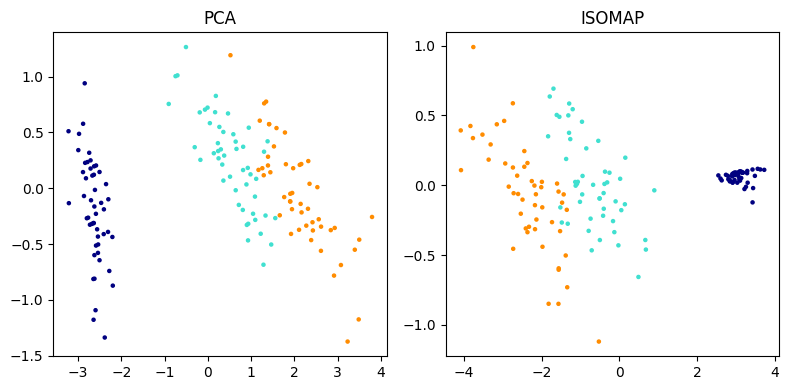

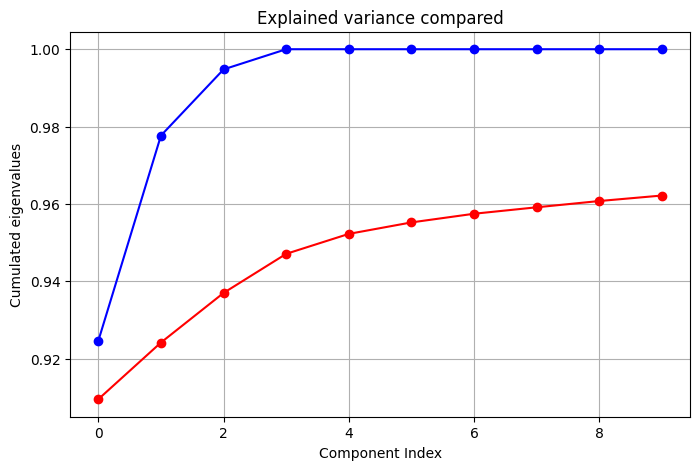

In [55]:
Eucl_dist_matrix = distance_matrix(X_iris,X_iris)
Xpca, eigs_pca = MDS_DIY(Eucl_dist_matrix)

kNN_dist_matrix = kNN_distance_matrix(X_iris, n_neighbors=30)
Xisomap, eigs_isomap = MDS_DIY(kNN_dist_matrix)

side_by_side_plot(Xpca,Xisomap,cols_iris)
side_by_side_decay(eigs_pca,eigs_isomap,10)

## Digits dataset
Compare PCA and ISOMAP on the Digits dataset. Play around with the number of nearest neighbors used for ISOMAP

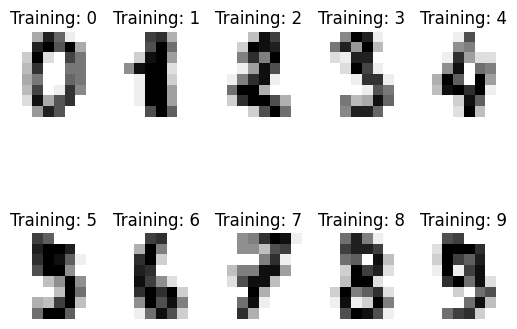

In [56]:
#Load and returns the digits dataset (classification) 
# Each datapoint is a 8x8 image of a digit
from sklearn.datasets import load_digits
digits = load_digits() 
Xd = digits.data
labels = digits.target
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

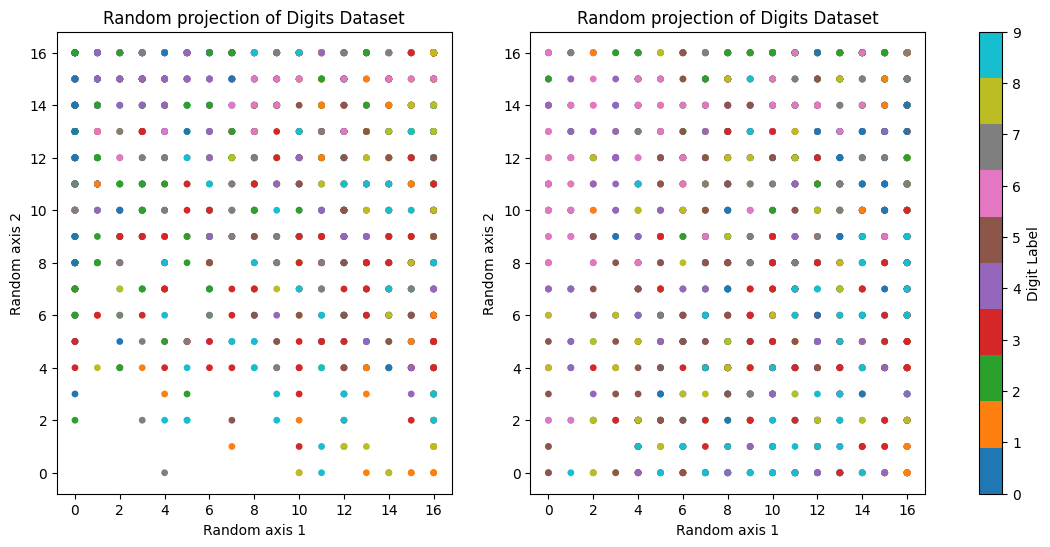

In [57]:
#Here is the dataset loaded with a random vizualisation of it.

# Extract features (X) and labels (y)
X_digits = digits.data
y_digits = digits.target

# Randomly pick two axes and projecting onto them
pick = random.sample(range(0,X_digits.shape[1],1),2)
y1 = X_digits[:,pick]

pick = random.sample(range(0,X_digits.shape[1],1),2)
y2 = X_digits[:,pick]

# Set up side-by-side plots for PCA and ISOMAP results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot PCA result
scatter1 = ax1.scatter(y1[:, 0], y1[:, 1], c=y_digits, cmap='tab10', s=15)
ax1.set_title("Random projection of Digits Dataset")
ax1.set_xlabel("Random axis 1")
ax1.set_ylabel("Random axis 2")

# Plot ISOMAP result
scatter2 = ax2.scatter(y2[:, 0], y2[:, 1], c=y_digits, cmap='tab10', s=15)
ax2.set_title("Random projection of Digits Dataset")
ax2.set_xlabel("Random axis 1")
ax2.set_ylabel("Random axis 2")

# Add colorbar for labels
fig.colorbar(scatter1, ax=[ax1, ax2], orientation='vertical', label="Digit Label")
plt.show()

# Show plot
plt.show()

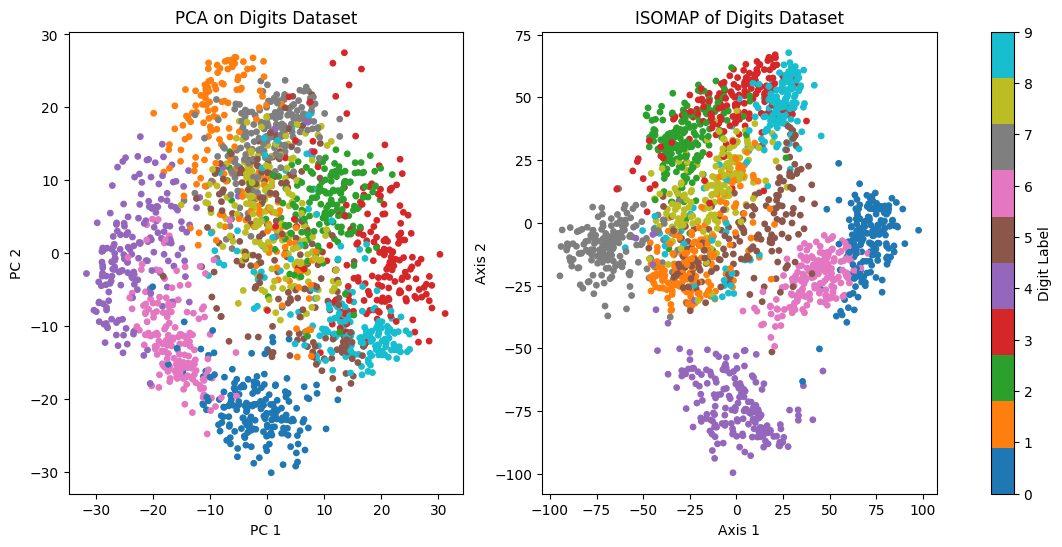

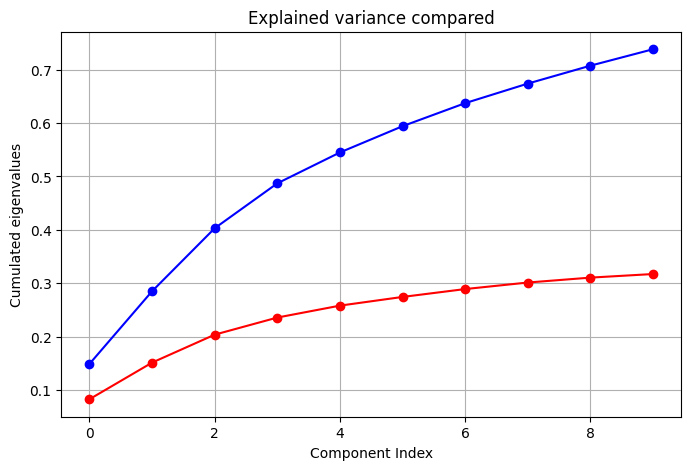

In [58]:
Eucl_dist_matrix = distance_matrix(X_digits,X_digits)
Xpca, eigs_pca = MDS_DIY(Eucl_dist_matrix)

kNN_dist_matrix = kNN_distance_matrix(X_digits, n_neighbors=30)
Xisomap, eigs_isomap = MDS_DIY(kNN_dist_matrix)


# Set up side-by-side plots for PCA and ISOMAP results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot PCA result
scatter1 = ax1.scatter(Xpca[:, 0], Xpca[:, 1], c=y_digits, cmap='tab10', s=15)
ax1.set_title("PCA on Digits Dataset")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")

# Plot ISOMAP result
scatter2 = ax2.scatter(Xisomap[:, 0], Xisomap[:, 1], c=y_digits, cmap='tab10', s=15)
ax2.set_title("ISOMAP of Digits Dataset")
ax2.set_xlabel("Axis 1")
ax2.set_ylabel("Axis 2")

# Add colorbar for labels
fig.colorbar(scatter1, ax=[ax1, ax2], orientation='vertical', label="Digit Label")
plt.show()

# Show plot
plt.show()

side_by_side_decay(eigs_pca,eigs_isomap,10)

Do the same in 3D

In [61]:
# Randomly pick two axes and projecting onto them
pick = random.sample(range(0,X_digits.shape[1],1),3)
y1 = X_digits[:,pick]

pick = random.sample(range(0,X_digits.shape[1],1),3)
y2 = X_digits[:,pick]

# Set up side-by-side 3D plots for PCA and ISOMAP results
fig = plt.figure(figsize=(14, 6))

# Plot PCA result
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(y1[:, 0], y1[:, 1], y1[:, 2], c=y_digits, cmap='tab10', s=15)
ax1.set_title("PCA on Digits Dataset")
ax1.set_xlabel("Random Component 1")
ax1.set_ylabel("Random Component 2")
ax1.set_zlabel("Random Component 3")

# Plot ISOMAP result
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(y2[:, 0], y2[:, 1], y2[:, 2], c=y_digits, cmap='tab10', s=15)
ax2.set_title("ISOMAP on Digits Dataset")
ax2.set_xlabel("Random Component 1")
ax2.set_ylabel("Random Component 2")
ax2.set_zlabel("Random Component 3")

# Add colorbar for labels
cbar = fig.colorbar(scatter1, ax=[ax1, ax2], orientation='vertical', pad=0.1, fraction=0.02, label="Digit Label")

plt.show()

In [59]:
Eucl_dist_matrix = distance_matrix(X_digits,X_digits)
Xpca, eigs_pca = MDS_DIY(Eucl_dist_matrix,dim=3)

kNN_dist_matrix = kNN_distance_matrix(X_digits, n_neighbors=20)
Xisomap, eigs_isomap = MDS_DIY(kNN_dist_matrix,dim=3)

# Set up side-by-side 3D plots for PCA and ISOMAP results
fig = plt.figure(figsize=(14, 6))

# Plot PCA result
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c=y_digits, cmap='tab10', s=15)
ax1.set_title("PCA on Digits Dataset")
ax1.set_xlabel("PCA Component 1")
ax1.set_ylabel("PCA Component 2")
ax1.set_zlabel("PCA Component 3")

# Plot ISOMAP result
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(Xisomap[:, 0], Xisomap[:, 1], Xisomap[:, 2], c=y_digits, cmap='tab10', s=15)
ax2.set_title("ISOMAP on Digits Dataset")
ax2.set_xlabel("ISOMAP Component 1")
ax2.set_ylabel("ISOMAP Component 2")
ax2.set_zlabel("ISOMAP Component 3")

# Add colorbar for labels
cbar = fig.colorbar(scatter1, ax=[ax1, ax2], orientation='vertical', pad=0.1, fraction=0.02, label="Digit Label")

plt.show()

### Additional experiments
    - Study how robust these two methods are to outliers
    - Explore how ISOMAP performs on the swiss roll dataset with a window